In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## **학습 & 테스트 프로세스 요약**
| 단계 | 학습 (Train) | 테스트 (Test) |
|------|------------|-------------|
| **1. 데이터 입력** | CSV 파일 (이미 추출된 특징값) | 동영상 |
| **2. 특징 추출** | CSV에서 불러오기 | 동영상 → 프레임 추출 → 12개 묶음 → 특징 추출 |
| **3. 데이터 변환** | `(배치, 12, 5)` 형태로 변환 | `(1, 12, 5)` 형태로 변환 |
| **4. 모델 학습/예측** | LSTM 모델 학습 | LSTM 모델을 이용해 예측 |
| **5. 결과 저장** | `.pth` 파일로 저장 | 예측값 출력 |


# 1. 학습

1. 추출된 feature 로드
2. LSTM Input 형식으로 변환
3. LSTM 학습

## 라이브러리 임포트

In [2]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from PIL import Image

from dataclasses import dataclass, field
from typing import Tuple, List

import warnings
warnings.filterwarnings('ignore')

from enum import Enum

class ModelType(Enum):
  BEST = "best"
  LAST = "last"

class DataType(Enum):
  TRAIN = "train"
  VAL = "val"
  TEST = "test"

base_dir = "/content/drive/MyDrive/DMS"


## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [3]:
from dataclasses import dataclass

@dataclass
class Config:
    case_name: str = "bi-lstm_attention_no_phone_detection" # 바꿔야하는 부분

    # 모델 구조
    lstm_num_layers: int = 3
    lstm_hidden_size: int = 512
    fc_hidden_size: int = 256
    dropout_rate: float = 0.2 # input-to-hidden (between layers)
    bidirectional: bool = True

    # 학습 설정
    batch_size: int = 32
    epochs: int = 100
    learning_rate: float = 3e-4
    optimizer: str = "adam" # or "sgd", "adamw"

    # 입력 데이터
    sequence_length: int = 12
    sliding_window_step: int = 12 # sliding window 사용 x -> seuqnce_length와 같은 값으로 설정
    features: list = field(default_factory=lambda: ["mar", "ear", "yaw", "pitch"]) # 수정한 부분
    labels: list = field(default_factory=lambda: ["normal", "phonecall", "text", "yawn"])

    apply_yaw_inversion: bool = False
    apply_noise_jittering: bool = False

    # 학습 제어 - 조기 종료 / 러닝레이트 스케줄러
    use_early_stopping: bool = False  # 조기 종료 사용 여부
    use_lr_scheduler: bool = False    # 학습률 스케줄러 사용 여부
    early_stopping_patience: int = 20 # early stopping 기준 epoch
    reduce_lr_factor: float = 0.5 # learning rate 감소 비율
    reduce_lr_patience: int = 7 # learning rate 감소 기준 epoch

    # 랜덤시드 설정
    random_seed: int = 24

    def __post_init__(self):
      self.results_save_path = f"{base_dir}/runs/{self.case_name}"
      self.model_save_path = f"{self.results_save_path}/weights"

      os.makedirs(self.results_save_path, exist_ok=True)
      os.makedirs(self.model_save_path, exist_ok=True)

      if self.sequence_length == 12:
        df_path = f'{base_dir}/data/splits/12frame_windows'
        self.group_col = 'groups_12'
      elif self.sequence_length == 24:
        df_path = f'{base_dir}/data/splits/24frame_windows'
        self.group_col = 'groups_24'

      self.train = pd.read_csv(os.path.join(df_path, "final_train.csv"))
      self.validation = pd.read_csv(os.path.join(df_path, "final_val.csv"))
      self.test = pd.read_csv(os.path.join(df_path, "final_test.csv"))

      # label_mapping
      self.label_encoding = {}
      self.label_decoding = {}
      for i, label in enumerate(self.labels):
          self.label_encoding[label] = i
          self.label_decoding[i] = label

      # 디바이스 설정
      self.use_cuda = torch.cuda.is_available()
      self.device = torch.device("cuda" if self.use_cuda else "cpu")

cfg = Config()
# print(cfg.case_name) # 사용 예시

In [4]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 연산에 대한 시드 설정
    torch.cuda.manual_seed(seed)  # CUDA 연산에 대한 시드 설정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU에 동일한 시드 설정
    np.random.seed(seed)  # NumPy 연산에 대한 시드 설정
    random.seed(seed)  # Python 기본 random 모듈의 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN 연산의 결정론적 동작 보장
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화 (재현성 보장)

set_random_seed(cfg.random_seed)

### 데이터 로드

### train, val, test 데이터셋 로드

In [5]:
train_df = cfg.train.copy()
val_df = cfg.validation.copy()
test_df = cfg.test.copy()

In [6]:
# train normal undersampling
train_df = train_df[((train_df['label'] == 'normal') &
                    (train_df[cfg.group_col].isin([1, 2]))) |
                    (train_df['label'] != 'normal')]

### generate_sequence_dataset

In [7]:
def generate_sequence_dataset(
    df: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray, List[Tuple]]:
    sequences, labels, metadata = [], [], []

    for (label, clip_id), clip_df in df.groupby(['label', 'clip_id']):
        clip_df = clip_df.sort_values('frame_no')
        frame_values = clip_df[cfg.features].values

        if len(frame_values) < cfg.sequence_length:
            continue

        for i in range(0, len(frame_values) - cfg.sequence_length + 1, cfg.sliding_window_step):
            seq = frame_values[i:i + cfg.sequence_length]
            if seq.shape[0] == cfg.sequence_length:
                sequences.append(seq)
                labels.append(cfg.label_encoding[label])
                # 학습 후 오분류 데이터 확인을 위한 시작 프레임 번호 저장
                metadata.append((label, clip_id, clip_df.iloc[i]['frame_no']))

    return TensorDataset(torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)), metadata

### DataLoader

In [8]:
train_params = {
    "batch_size": cfg.batch_size,
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": cfg.use_cuda,
    "persistent_workers": cfg.use_cuda,
    "prefetch_factor": 2 if cfg.use_cuda else None,
}

test_params = {
    "batch_size": cfg.batch_size,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": cfg.use_cuda
}

In [9]:
# DataLoader 생성 (배치 단위로 데이터를 나누기 위해 사용)
train_dataset, train_metadata = generate_sequence_dataset(train_df)
val_dataset, val_metadata = generate_sequence_dataset(val_df)
test_dataset, test_metadata = generate_sequence_dataset(test_df)

train_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **test_params)
test_loader = DataLoader(test_dataset, **test_params)

# 배치 단위 확인
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in val_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 12, 4]) torch.Size([32])
Batch Shape: torch.Size([32, 12, 4]) torch.Size([32])
Batch Shape: torch.Size([32, 12, 4]) torch.Size([32])


## 1-3. LSTM 학습 설정

### 모델 정의

In [10]:
# Attention 모듈 정의
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: [B, T, H]
        score = torch.tanh(self.attn(lstm_output))         # [B, T, H]
        attn_weights = torch.softmax(self.context(score), dim=1)  # [B, T, 1]
        attended_output = torch.sum(attn_weights * lstm_output, dim=1)  # [B, H]
        return attended_output, attn_weights  # context vector, weights

In [11]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = len(cfg.features)
        self.h_RNN_layers = cfg.lstm_num_layers
        self.h_RNN = cfg.lstm_hidden_size
        self.h_FC_dim = cfg.fc_hidden_size
        self.drop_p = cfg.dropout_rate
        self.num_classes = len(cfg.labels)
        self.bidirectional = cfg.bidirectional

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

        lstm_output_dim = self.h_RNN * (2 if self.bidirectional else 1)

        self.attention = Attention(lstm_output_dim) # Attention 추가
        self.fc1 = nn.Linear(lstm_output_dim, self.h_FC_dim)
        self.bn1 = nn.BatchNorm1d(self.h_FC_dim)  # Batch Normalization 추가
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        out, _ = self.LSTM(x_RNN)  # (batch, seq_len, hidden*2)

        attn_out, attn_weights = self.attention(out)  # attn_out: [B, H]

        # FC layers
        x = self.fc1(attn_out)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x, attn_weights  # CrossEntropyLoss 사용 (Softmax 없음), attn_weights 함께 반환

### optimizer

- 모델 구조 비교: Adam 고정
- 정규화/튜닝 단계: Adam, AdamW, SGD 비교
- 최종 성능 극대화: weight decay, scheduler, mixed precision 등과 조합 실험

In [12]:
def get_optimizer(model):
    if cfg.optimizer.lower() == "adam":
        return optim.Adam(model.parameters(), lr=cfg.learning_rate)
    elif cfg.optimizer.lower() == "sgd":
        return optim.SGD(model.parameters(), lr=cfg.learning_rate, momentum=0.9)
    elif cfg.optimizer.lower() == "adamw":
        return optim.AdamW(model.parameters(), lr=cfg.learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {cfg.optimizer}")

def get_criterion():
  return nn.CrossEntropyLoss()

### 학습 스케줄러 설정

In [13]:
def get_scheduler(optimizer):
    return optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",  # 'min' for loss, 'max' for accuracy/f1
        factor=cfg.reduce_lr_factor,
        patience=cfg.reduce_lr_patience,
)

### Early Stopping 설정

In [14]:
class EarlyStopping:
    def __init__(self, mode: str = "min"):
        self.patience = cfg.early_stopping_patience
        self.mode = mode
        self.best_score = np.inf if mode == "min" else -np.inf
        self.counter = 0
        self.early_stop = False

    def step(self, current_score: float) -> bool:
        """
        평가 점수(current_score)를 받아 early stopping 여부를 업데이트함.
        Returns:
            True if training should stop
        """
        if self.mode == "min":
            is_improvement = current_score < self.best_score
        else:  # "max"
            is_improvement = current_score > self.best_score

        if is_improvement:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

## 1-4 학습 진행

-  Gradient Clipping 추가 (torch.nn.utils.clip_grad_norm_()) → 폭발적인 기울기(Gradient Explosion) 방지
- 모델 저장 기능 추가 (torch.save()) → Best Loss 갱신 시 자동 저장

In [15]:
def save_model(model, optimizer, epoch, loss, model_type): # model_type: "best", "last"
    model_filename = f"{cfg.model_save_path}/{model_type}_model.pth"  # 저장 파일명

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, model_filename)

    print(f"💾 Model Updated! Saved at {model_filename} (Loss: {loss:.4f})")

def save_training_results(
        train_losses,
        train_scores,
        val_losses,
        val_scores,
        ):
    """
    학습 과정의 손실(loss)과 정확도(score)를 저장하는 함수
    """
    results_df = pd.DataFrame({
        "epoch": list(range(1, len(train_losses) + 1)),
        "train_loss": train_losses,
        "train_accuracy": train_scores,
        "val_loss": val_losses,
        "val_accuracy": val_scores,
    })

    results_df.to_csv(f"{cfg.results_save_path}/training_results.csv", index=False)
    print(f"💾 Training results saved at {cfg.results_save_path}/training_results.csv")

### epoch마다 validation data로 성능평가
- 다음 기술을 적용하는 기준: Validation data Loss
    - validation data 기준으로 best model 선정
    - 모델 저장 (Best Loss 갱신 시)

### train & validate

In [16]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    losses, scores = [], []

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        X, y = X.to(device), y.to(device).long()

        optimizer.zero_grad()
        output = model(X)

        # 튜플 처리
        if isinstance(output, tuple):
            output = output[0]

        loss = criterion(output, y)
        loss.backward() # 역전파

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #  Gradient Clipping
        optimizer.step()

        losses.append(loss.item())

        # 정확도 계산
        y_pred = torch.argmax(output, dim=1)
        acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
        scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"✅ Train Epoch {epoch+1} Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

    return avg_loss, avg_acc  # 학습 Loss 및 Accuracy 반환

def validate(model, device, criterion, val_loader):
    model.eval()
    losses, scores = [], []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device).long()
            output = model(X)

            # 튜플 처리
            if isinstance(output, tuple):
                output = output[0]
            loss = criterion(output, y)

            losses.append(loss.item())

            y_pred = torch.argmax(output, dim=1)
            acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
            scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"✅ Validation Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

    return avg_loss, avg_acc  # 검증 Loss 및 Accuracy 반환

In [17]:
# 전체 학습 실행 코드
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, scheduler=None):
    best_loss = np.inf

    train_losses, train_scores = [], []
    val_losses, val_scores = [], []

    for epoch in range(cfg.epochs):
        # 학습 단계
        train_loss, train_score = train(
            model=model,
            device=cfg.device,
            train_loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            epoch=epoch
        )

        val_loss, val_score = validate(
            model=model,
            device=cfg.device,
            criterion=criterion,
            val_loader=val_loader
        )

        train_losses.append(train_loss)
        train_scores.append(train_score)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        # 학습률 감소 적용
        if cfg.use_lr_scheduler:
          pass

        # Best model 저장
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0

            save_model(
                model=model,
                optimizer=optimizer,
                epoch=epoch,
                loss=best_loss,
                model_type="best"
            )

            print(f"Best Loss Updated! : {best_loss}")

        # Early Stopping 체크
        if cfg.use_early_stopping:
          pass

    # 마지막 모델 저장
    save_model(
      model=model,
      optimizer=optimizer,
      epoch=epoch,
      loss=val_loss,
      model_type="last"
    )

    # 학습 결과 저장
    save_training_results(
      train_losses,
      train_scores,
      val_losses,
      val_scores
    )

    return train_losses, train_scores, val_losses, val_scores

In [18]:
model = DecoderRNN()
model.to(cfg.device)

optimizer = get_optimizer(model)
criterion = get_criterion()

scheduler = get_scheduler(optimizer, cfg) if cfg.use_lr_scheduler else None

train_losses, train_scores, valid_losses, valid_scores = train_and_validate(
    model, train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1 [Train]: 100%|██████████| 145/145 [00:04<00:00, 33.16it/s]


✅ Train Epoch 1 Finished - Avg Loss: 0.8061, Avg Acc: 69.55%
✅ Validation Finished - Avg Loss: 1.1815, Avg Acc: 53.85%
💾 Model Updated! Saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/best_model.pth (Loss: 1.1815)
Best Loss Updated! : 1.1815295409072528


Epoch 2 [Train]: 100%|██████████| 145/145 [00:03<00:00, 46.44it/s]


✅ Train Epoch 2 Finished - Avg Loss: 0.6576, Avg Acc: 75.89%
✅ Validation Finished - Avg Loss: 1.0586, Avg Acc: 57.58%
💾 Model Updated! Saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/best_model.pth (Loss: 1.0586)
Best Loss Updated! : 1.0585779026150703


Epoch 3 [Train]: 100%|██████████| 145/145 [00:03<00:00, 46.72it/s]


✅ Train Epoch 3 Finished - Avg Loss: 0.6071, Avg Acc: 78.09%
✅ Validation Finished - Avg Loss: 0.9850, Avg Acc: 55.23%
💾 Model Updated! Saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/best_model.pth (Loss: 0.9850)
Best Loss Updated! : 0.9850065918131308


Epoch 4 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.28it/s]


✅ Train Epoch 4 Finished - Avg Loss: 0.5873, Avg Acc: 78.85%
✅ Validation Finished - Avg Loss: 0.9168, Avg Acc: 59.66%
💾 Model Updated! Saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/best_model.pth (Loss: 0.9168)
Best Loss Updated! : 0.9167735596949403


Epoch 5 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.78it/s]


✅ Train Epoch 5 Finished - Avg Loss: 0.5614, Avg Acc: 79.95%
✅ Validation Finished - Avg Loss: 0.9841, Avg Acc: 57.72%


Epoch 6 [Train]: 100%|██████████| 145/145 [00:03<00:00, 46.74it/s]


✅ Train Epoch 6 Finished - Avg Loss: 0.5494, Avg Acc: 80.41%
✅ Validation Finished - Avg Loss: 1.0388, Avg Acc: 59.00%


Epoch 7 [Train]: 100%|██████████| 145/145 [00:03<00:00, 45.57it/s]


✅ Train Epoch 7 Finished - Avg Loss: 0.5410, Avg Acc: 80.62%
✅ Validation Finished - Avg Loss: 0.9444, Avg Acc: 60.28%


Epoch 8 [Train]: 100%|██████████| 145/145 [00:03<00:00, 40.17it/s]


✅ Train Epoch 8 Finished - Avg Loss: 0.5374, Avg Acc: 80.78%
✅ Validation Finished - Avg Loss: 0.9557, Avg Acc: 60.14%


Epoch 9 [Train]: 100%|██████████| 145/145 [00:03<00:00, 46.14it/s]


✅ Train Epoch 9 Finished - Avg Loss: 0.5374, Avg Acc: 81.21%
✅ Validation Finished - Avg Loss: 1.0012, Avg Acc: 59.21%


Epoch 10 [Train]: 100%|██████████| 145/145 [00:03<00:00, 45.98it/s]


✅ Train Epoch 10 Finished - Avg Loss: 0.5436, Avg Acc: 80.66%
✅ Validation Finished - Avg Loss: 0.9315, Avg Acc: 60.64%


Epoch 11 [Train]: 100%|██████████| 145/145 [00:03<00:00, 45.98it/s]


✅ Train Epoch 11 Finished - Avg Loss: 0.5243, Avg Acc: 81.25%
✅ Validation Finished - Avg Loss: 0.9067, Avg Acc: 60.93%
💾 Model Updated! Saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/best_model.pth (Loss: 0.9067)
Best Loss Updated! : 0.9066514487970959


Epoch 12 [Train]: 100%|██████████| 145/145 [00:04<00:00, 29.64it/s]


✅ Train Epoch 12 Finished - Avg Loss: 0.5192, Avg Acc: 81.25%
✅ Validation Finished - Avg Loss: 0.9295, Avg Acc: 61.71%


Epoch 13 [Train]: 100%|██████████| 145/145 [00:03<00:00, 46.15it/s]


✅ Train Epoch 13 Finished - Avg Loss: 0.5204, Avg Acc: 81.35%
✅ Validation Finished - Avg Loss: 1.0252, Avg Acc: 58.45%


Epoch 14 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.67it/s]


✅ Train Epoch 14 Finished - Avg Loss: 0.4984, Avg Acc: 81.60%
✅ Validation Finished - Avg Loss: 0.9184, Avg Acc: 60.58%


Epoch 15 [Train]: 100%|██████████| 145/145 [00:04<00:00, 30.47it/s]


✅ Train Epoch 15 Finished - Avg Loss: 0.4987, Avg Acc: 81.84%
✅ Validation Finished - Avg Loss: 0.9003, Avg Acc: 60.98%
💾 Model Updated! Saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/best_model.pth (Loss: 0.9003)
Best Loss Updated! : 0.9003021361475642


Epoch 16 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.55it/s]


✅ Train Epoch 16 Finished - Avg Loss: 0.4949, Avg Acc: 82.71%
✅ Validation Finished - Avg Loss: 0.9380, Avg Acc: 61.71%


Epoch 17 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.14it/s]


✅ Train Epoch 17 Finished - Avg Loss: 0.4812, Avg Acc: 82.59%
✅ Validation Finished - Avg Loss: 1.0344, Avg Acc: 60.29%


Epoch 18 [Train]: 100%|██████████| 145/145 [00:03<00:00, 40.40it/s]


✅ Train Epoch 18 Finished - Avg Loss: 0.4853, Avg Acc: 82.40%
✅ Validation Finished - Avg Loss: 0.9346, Avg Acc: 61.43%


Epoch 19 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.19it/s]


✅ Train Epoch 19 Finished - Avg Loss: 0.4735, Avg Acc: 83.22%
✅ Validation Finished - Avg Loss: 0.9875, Avg Acc: 61.20%


Epoch 20 [Train]: 100%|██████████| 145/145 [00:03<00:00, 42.85it/s]


✅ Train Epoch 20 Finished - Avg Loss: 0.4739, Avg Acc: 83.04%
✅ Validation Finished - Avg Loss: 0.8872, Avg Acc: 62.42%
💾 Model Updated! Saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/best_model.pth (Loss: 0.8872)
Best Loss Updated! : 0.8871925126083873


Epoch 21 [Train]: 100%|██████████| 145/145 [00:03<00:00, 41.58it/s]


✅ Train Epoch 21 Finished - Avg Loss: 0.4660, Avg Acc: 83.11%
✅ Validation Finished - Avg Loss: 0.9144, Avg Acc: 64.48%


Epoch 22 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.52it/s]


✅ Train Epoch 22 Finished - Avg Loss: 0.4593, Avg Acc: 83.40%
✅ Validation Finished - Avg Loss: 0.9272, Avg Acc: 62.99%


Epoch 23 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.53it/s]


✅ Train Epoch 23 Finished - Avg Loss: 0.4572, Avg Acc: 83.64%
✅ Validation Finished - Avg Loss: 0.9594, Avg Acc: 61.36%


Epoch 24 [Train]: 100%|██████████| 145/145 [00:03<00:00, 36.59it/s]


✅ Train Epoch 24 Finished - Avg Loss: 0.4527, Avg Acc: 83.71%
✅ Validation Finished - Avg Loss: 0.9804, Avg Acc: 62.35%


Epoch 25 [Train]: 100%|██████████| 145/145 [00:04<00:00, 32.16it/s]


✅ Train Epoch 25 Finished - Avg Loss: 0.4487, Avg Acc: 84.43%
✅ Validation Finished - Avg Loss: 1.0252, Avg Acc: 62.35%


Epoch 26 [Train]: 100%|██████████| 145/145 [00:03<00:00, 42.10it/s]


✅ Train Epoch 26 Finished - Avg Loss: 0.4353, Avg Acc: 83.90%
✅ Validation Finished - Avg Loss: 0.9021, Avg Acc: 63.06%


Epoch 27 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.54it/s]


✅ Train Epoch 27 Finished - Avg Loss: 0.4376, Avg Acc: 84.33%
✅ Validation Finished - Avg Loss: 0.9005, Avg Acc: 62.78%


Epoch 28 [Train]: 100%|██████████| 145/145 [00:03<00:00, 41.07it/s]


✅ Train Epoch 28 Finished - Avg Loss: 0.4310, Avg Acc: 84.27%
✅ Validation Finished - Avg Loss: 0.9125, Avg Acc: 65.05%


Epoch 29 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.25it/s]


✅ Train Epoch 29 Finished - Avg Loss: 0.4233, Avg Acc: 84.13%
✅ Validation Finished - Avg Loss: 0.9365, Avg Acc: 63.63%


Epoch 30 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.42it/s]


✅ Train Epoch 30 Finished - Avg Loss: 0.4209, Avg Acc: 84.81%
✅ Validation Finished - Avg Loss: 0.9929, Avg Acc: 63.29%


Epoch 31 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.58it/s]


✅ Train Epoch 31 Finished - Avg Loss: 0.4202, Avg Acc: 84.87%
✅ Validation Finished - Avg Loss: 0.8867, Avg Acc: 64.71%
💾 Model Updated! Saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/best_model.pth (Loss: 0.8867)
Best Loss Updated! : 0.8867282886058092


Epoch 32 [Train]: 100%|██████████| 145/145 [00:03<00:00, 41.80it/s]


✅ Train Epoch 32 Finished - Avg Loss: 0.4117, Avg Acc: 85.13%
✅ Validation Finished - Avg Loss: 0.9907, Avg Acc: 64.63%


Epoch 33 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.93it/s]


✅ Train Epoch 33 Finished - Avg Loss: 0.4058, Avg Acc: 85.05%
✅ Validation Finished - Avg Loss: 0.9107, Avg Acc: 64.77%


Epoch 34 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.64it/s]


✅ Train Epoch 34 Finished - Avg Loss: 0.3965, Avg Acc: 85.70%
✅ Validation Finished - Avg Loss: 0.9840, Avg Acc: 63.29%


Epoch 35 [Train]: 100%|██████████| 145/145 [00:04<00:00, 30.95it/s]


✅ Train Epoch 35 Finished - Avg Loss: 0.3863, Avg Acc: 86.01%
✅ Validation Finished - Avg Loss: 0.8945, Avg Acc: 62.42%


Epoch 36 [Train]: 100%|██████████| 145/145 [00:03<00:00, 36.90it/s]


✅ Train Epoch 36 Finished - Avg Loss: 0.3850, Avg Acc: 86.13%
✅ Validation Finished - Avg Loss: 0.9792, Avg Acc: 63.35%


Epoch 37 [Train]: 100%|██████████| 145/145 [00:03<00:00, 39.91it/s]


✅ Train Epoch 37 Finished - Avg Loss: 0.3746, Avg Acc: 86.36%
✅ Validation Finished - Avg Loss: 0.9981, Avg Acc: 64.07%


Epoch 38 [Train]: 100%|██████████| 145/145 [00:03<00:00, 40.69it/s]


✅ Train Epoch 38 Finished - Avg Loss: 0.3693, Avg Acc: 86.10%
✅ Validation Finished - Avg Loss: 0.8947, Avg Acc: 64.55%


Epoch 39 [Train]: 100%|██████████| 145/145 [00:03<00:00, 39.43it/s]


✅ Train Epoch 39 Finished - Avg Loss: 0.3588, Avg Acc: 86.75%
✅ Validation Finished - Avg Loss: 0.9800, Avg Acc: 63.07%


Epoch 40 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.07it/s]


✅ Train Epoch 40 Finished - Avg Loss: 0.3517, Avg Acc: 87.43%
✅ Validation Finished - Avg Loss: 0.9551, Avg Acc: 65.20%


Epoch 41 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.18it/s]


✅ Train Epoch 41 Finished - Avg Loss: 0.3317, Avg Acc: 87.37%
✅ Validation Finished - Avg Loss: 1.0577, Avg Acc: 63.50%


Epoch 42 [Train]: 100%|██████████| 145/145 [00:03<00:00, 40.27it/s]


✅ Train Epoch 42 Finished - Avg Loss: 0.3221, Avg Acc: 87.98%
✅ Validation Finished - Avg Loss: 1.0431, Avg Acc: 64.07%


Epoch 43 [Train]: 100%|██████████| 145/145 [00:03<00:00, 42.99it/s]


✅ Train Epoch 43 Finished - Avg Loss: 0.3230, Avg Acc: 87.97%
✅ Validation Finished - Avg Loss: 1.0574, Avg Acc: 65.05%


Epoch 44 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.82it/s]


✅ Train Epoch 44 Finished - Avg Loss: 0.3069, Avg Acc: 88.48%
✅ Validation Finished - Avg Loss: 1.0513, Avg Acc: 65.07%


Epoch 45 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.65it/s]


✅ Train Epoch 45 Finished - Avg Loss: 0.3064, Avg Acc: 88.53%
✅ Validation Finished - Avg Loss: 1.0703, Avg Acc: 65.70%


Epoch 46 [Train]: 100%|██████████| 145/145 [00:03<00:00, 40.11it/s]


✅ Train Epoch 46 Finished - Avg Loss: 0.2862, Avg Acc: 89.06%
✅ Validation Finished - Avg Loss: 1.1321, Avg Acc: 64.43%


Epoch 47 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.66it/s]


✅ Train Epoch 47 Finished - Avg Loss: 0.2786, Avg Acc: 89.13%
✅ Validation Finished - Avg Loss: 1.1626, Avg Acc: 64.71%


Epoch 48 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.14it/s]


✅ Train Epoch 48 Finished - Avg Loss: 0.2617, Avg Acc: 89.79%
✅ Validation Finished - Avg Loss: 1.3563, Avg Acc: 63.99%


Epoch 49 [Train]: 100%|██████████| 145/145 [00:03<00:00, 39.87it/s]


✅ Train Epoch 49 Finished - Avg Loss: 0.2614, Avg Acc: 90.39%
✅ Validation Finished - Avg Loss: 1.2206, Avg Acc: 65.83%


Epoch 50 [Train]: 100%|██████████| 145/145 [00:03<00:00, 39.94it/s]


✅ Train Epoch 50 Finished - Avg Loss: 0.2532, Avg Acc: 90.90%
✅ Validation Finished - Avg Loss: 1.3381, Avg Acc: 63.85%


Epoch 51 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.29it/s]


✅ Train Epoch 51 Finished - Avg Loss: 0.2326, Avg Acc: 91.53%
✅ Validation Finished - Avg Loss: 1.3339, Avg Acc: 64.41%


Epoch 52 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.87it/s]


✅ Train Epoch 52 Finished - Avg Loss: 0.2199, Avg Acc: 91.68%
✅ Validation Finished - Avg Loss: 1.4391, Avg Acc: 64.42%


Epoch 53 [Train]: 100%|██████████| 145/145 [00:03<00:00, 40.29it/s]


✅ Train Epoch 53 Finished - Avg Loss: 0.2184, Avg Acc: 91.67%
✅ Validation Finished - Avg Loss: 1.4080, Avg Acc: 65.78%


Epoch 54 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.51it/s]


✅ Train Epoch 54 Finished - Avg Loss: 0.1990, Avg Acc: 92.84%
✅ Validation Finished - Avg Loss: 1.3975, Avg Acc: 64.50%


Epoch 55 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.68it/s]


✅ Train Epoch 55 Finished - Avg Loss: 0.1824, Avg Acc: 92.87%
✅ Validation Finished - Avg Loss: 1.5466, Avg Acc: 65.50%


Epoch 56 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.21it/s]


✅ Train Epoch 56 Finished - Avg Loss: 0.1766, Avg Acc: 93.44%
✅ Validation Finished - Avg Loss: 1.4507, Avg Acc: 65.15%


Epoch 57 [Train]: 100%|██████████| 145/145 [00:03<00:00, 41.53it/s]


✅ Train Epoch 57 Finished - Avg Loss: 0.1651, Avg Acc: 93.88%
✅ Validation Finished - Avg Loss: 1.7927, Avg Acc: 64.57%


Epoch 58 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.86it/s]


✅ Train Epoch 58 Finished - Avg Loss: 0.1457, Avg Acc: 94.70%
✅ Validation Finished - Avg Loss: 1.8325, Avg Acc: 63.49%


Epoch 59 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.52it/s]


✅ Train Epoch 59 Finished - Avg Loss: 0.1554, Avg Acc: 94.28%
✅ Validation Finished - Avg Loss: 1.7031, Avg Acc: 66.49%


Epoch 60 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.02it/s]


✅ Train Epoch 60 Finished - Avg Loss: 0.1406, Avg Acc: 94.73%
✅ Validation Finished - Avg Loss: 1.8452, Avg Acc: 64.00%


Epoch 61 [Train]: 100%|██████████| 145/145 [00:03<00:00, 42.69it/s]


✅ Train Epoch 61 Finished - Avg Loss: 0.1254, Avg Acc: 95.40%
✅ Validation Finished - Avg Loss: 1.9028, Avg Acc: 65.71%


Epoch 62 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.98it/s]


✅ Train Epoch 62 Finished - Avg Loss: 0.1205, Avg Acc: 96.03%
✅ Validation Finished - Avg Loss: 1.8327, Avg Acc: 64.14%


Epoch 63 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.87it/s]


✅ Train Epoch 63 Finished - Avg Loss: 0.1145, Avg Acc: 96.16%
✅ Validation Finished - Avg Loss: 1.9458, Avg Acc: 65.16%


Epoch 64 [Train]: 100%|██████████| 145/145 [00:03<00:00, 41.25it/s]


✅ Train Epoch 64 Finished - Avg Loss: 0.1028, Avg Acc: 96.27%
✅ Validation Finished - Avg Loss: 2.0619, Avg Acc: 64.51%


Epoch 65 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.28it/s]


✅ Train Epoch 65 Finished - Avg Loss: 0.0930, Avg Acc: 96.82%
✅ Validation Finished - Avg Loss: 2.0300, Avg Acc: 65.35%


Epoch 66 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.96it/s]


✅ Train Epoch 66 Finished - Avg Loss: 0.1197, Avg Acc: 95.96%
✅ Validation Finished - Avg Loss: 2.1543, Avg Acc: 64.77%


Epoch 67 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.80it/s]


✅ Train Epoch 67 Finished - Avg Loss: 0.1080, Avg Acc: 96.44%
✅ Validation Finished - Avg Loss: 2.3409, Avg Acc: 64.20%


Epoch 68 [Train]: 100%|██████████| 145/145 [00:03<00:00, 41.32it/s]


✅ Train Epoch 68 Finished - Avg Loss: 0.0893, Avg Acc: 97.10%
✅ Validation Finished - Avg Loss: 2.1346, Avg Acc: 64.03%


Epoch 69 [Train]: 100%|██████████| 145/145 [00:03<00:00, 45.07it/s]


✅ Train Epoch 69 Finished - Avg Loss: 0.0900, Avg Acc: 96.92%
✅ Validation Finished - Avg Loss: 2.5399, Avg Acc: 63.92%


Epoch 70 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.75it/s]


✅ Train Epoch 70 Finished - Avg Loss: 0.0830, Avg Acc: 96.96%
✅ Validation Finished - Avg Loss: 2.4723, Avg Acc: 63.78%


Epoch 71 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.46it/s]


✅ Train Epoch 71 Finished - Avg Loss: 0.0766, Avg Acc: 97.65%
✅ Validation Finished - Avg Loss: 2.2768, Avg Acc: 63.58%


Epoch 72 [Train]: 100%|██████████| 145/145 [00:03<00:00, 42.19it/s]


✅ Train Epoch 72 Finished - Avg Loss: 0.0632, Avg Acc: 98.00%
✅ Validation Finished - Avg Loss: 2.3234, Avg Acc: 64.27%


Epoch 73 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.89it/s]


✅ Train Epoch 73 Finished - Avg Loss: 0.0612, Avg Acc: 97.99%
✅ Validation Finished - Avg Loss: 2.3740, Avg Acc: 63.28%


Epoch 74 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.70it/s]


✅ Train Epoch 74 Finished - Avg Loss: 0.0611, Avg Acc: 98.19%
✅ Validation Finished - Avg Loss: 2.6051, Avg Acc: 64.91%


Epoch 75 [Train]: 100%|██████████| 145/145 [00:03<00:00, 42.06it/s]


✅ Train Epoch 75 Finished - Avg Loss: 0.0699, Avg Acc: 97.95%
✅ Validation Finished - Avg Loss: 2.6026, Avg Acc: 64.56%


Epoch 76 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.96it/s]


✅ Train Epoch 76 Finished - Avg Loss: 0.0661, Avg Acc: 97.97%
✅ Validation Finished - Avg Loss: 2.6765, Avg Acc: 64.64%


Epoch 77 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.57it/s]


✅ Train Epoch 77 Finished - Avg Loss: 0.0691, Avg Acc: 97.50%
✅ Validation Finished - Avg Loss: 2.8113, Avg Acc: 64.08%


Epoch 78 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.86it/s]


✅ Train Epoch 78 Finished - Avg Loss: 0.0621, Avg Acc: 98.17%
✅ Validation Finished - Avg Loss: 2.5827, Avg Acc: 64.77%


Epoch 79 [Train]: 100%|██████████| 145/145 [00:03<00:00, 40.49it/s]


✅ Train Epoch 79 Finished - Avg Loss: 0.0480, Avg Acc: 98.32%
✅ Validation Finished - Avg Loss: 2.8338, Avg Acc: 65.48%


Epoch 80 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.66it/s]


✅ Train Epoch 80 Finished - Avg Loss: 0.0522, Avg Acc: 98.36%
✅ Validation Finished - Avg Loss: 2.7420, Avg Acc: 65.13%


Epoch 81 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.66it/s]


✅ Train Epoch 81 Finished - Avg Loss: 0.0377, Avg Acc: 98.66%
✅ Validation Finished - Avg Loss: 2.8271, Avg Acc: 63.99%


Epoch 82 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.99it/s]


✅ Train Epoch 82 Finished - Avg Loss: 0.0472, Avg Acc: 98.45%
✅ Validation Finished - Avg Loss: 2.8470, Avg Acc: 65.05%


Epoch 83 [Train]: 100%|██████████| 145/145 [00:03<00:00, 42.27it/s]


✅ Train Epoch 83 Finished - Avg Loss: 0.0532, Avg Acc: 98.10%
✅ Validation Finished - Avg Loss: 2.5716, Avg Acc: 64.84%


Epoch 84 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.68it/s]


✅ Train Epoch 84 Finished - Avg Loss: 0.0561, Avg Acc: 98.38%
✅ Validation Finished - Avg Loss: 2.6957, Avg Acc: 65.34%


Epoch 85 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.80it/s]


✅ Train Epoch 85 Finished - Avg Loss: 0.0487, Avg Acc: 98.66%
✅ Validation Finished - Avg Loss: 2.8645, Avg Acc: 64.84%


Epoch 86 [Train]: 100%|██████████| 145/145 [00:03<00:00, 42.02it/s]


✅ Train Epoch 86 Finished - Avg Loss: 0.0389, Avg Acc: 98.84%
✅ Validation Finished - Avg Loss: 3.0819, Avg Acc: 64.55%


Epoch 87 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.44it/s]


✅ Train Epoch 87 Finished - Avg Loss: 0.0418, Avg Acc: 98.62%
✅ Validation Finished - Avg Loss: 3.2042, Avg Acc: 64.13%


Epoch 88 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.57it/s]


✅ Train Epoch 88 Finished - Avg Loss: 0.0361, Avg Acc: 98.84%
✅ Validation Finished - Avg Loss: 3.0223, Avg Acc: 65.20%


Epoch 89 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.66it/s]


✅ Train Epoch 89 Finished - Avg Loss: 0.0308, Avg Acc: 99.22%
✅ Validation Finished - Avg Loss: 3.0621, Avg Acc: 66.54%


Epoch 90 [Train]: 100%|██████████| 145/145 [00:03<00:00, 40.61it/s]


✅ Train Epoch 90 Finished - Avg Loss: 0.0550, Avg Acc: 98.42%
✅ Validation Finished - Avg Loss: 3.2074, Avg Acc: 63.42%


Epoch 91 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.81it/s]


✅ Train Epoch 91 Finished - Avg Loss: 0.0438, Avg Acc: 98.79%
✅ Validation Finished - Avg Loss: 3.1579, Avg Acc: 65.18%


Epoch 92 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.89it/s]


✅ Train Epoch 92 Finished - Avg Loss: 0.0435, Avg Acc: 98.79%
✅ Validation Finished - Avg Loss: 3.2040, Avg Acc: 63.91%


Epoch 93 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.85it/s]


✅ Train Epoch 93 Finished - Avg Loss: 0.0593, Avg Acc: 98.21%
✅ Validation Finished - Avg Loss: 3.0960, Avg Acc: 64.86%


Epoch 94 [Train]: 100%|██████████| 145/145 [00:03<00:00, 41.61it/s]


✅ Train Epoch 94 Finished - Avg Loss: 0.0595, Avg Acc: 98.32%
✅ Validation Finished - Avg Loss: 3.0221, Avg Acc: 64.01%


Epoch 95 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.70it/s]


✅ Train Epoch 95 Finished - Avg Loss: 0.0462, Avg Acc: 98.64%
✅ Validation Finished - Avg Loss: 3.3152, Avg Acc: 63.35%


Epoch 96 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.78it/s]


✅ Train Epoch 96 Finished - Avg Loss: 0.0303, Avg Acc: 98.94%
✅ Validation Finished - Avg Loss: 3.3417, Avg Acc: 63.56%


Epoch 97 [Train]: 100%|██████████| 145/145 [00:03<00:00, 42.28it/s]


✅ Train Epoch 97 Finished - Avg Loss: 0.0425, Avg Acc: 98.64%
✅ Validation Finished - Avg Loss: 3.3557, Avg Acc: 63.71%


Epoch 98 [Train]: 100%|██████████| 145/145 [00:03<00:00, 43.33it/s]


✅ Train Epoch 98 Finished - Avg Loss: 0.0246, Avg Acc: 99.20%
✅ Validation Finished - Avg Loss: 3.2267, Avg Acc: 64.34%


Epoch 99 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.81it/s]


✅ Train Epoch 99 Finished - Avg Loss: 0.0354, Avg Acc: 98.88%
✅ Validation Finished - Avg Loss: 3.1667, Avg Acc: 64.76%


Epoch 100 [Train]: 100%|██████████| 145/145 [00:03<00:00, 44.61it/s]


✅ Train Epoch 100 Finished - Avg Loss: 0.0284, Avg Acc: 99.24%
✅ Validation Finished - Avg Loss: 3.3707, Avg Acc: 65.47%
💾 Model Updated! Saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/last_model.pth (Loss: 3.3707)
💾 Training results saved at /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/training_results.csv


# 2. 결과 시각화

## loss, accuracy 시각화

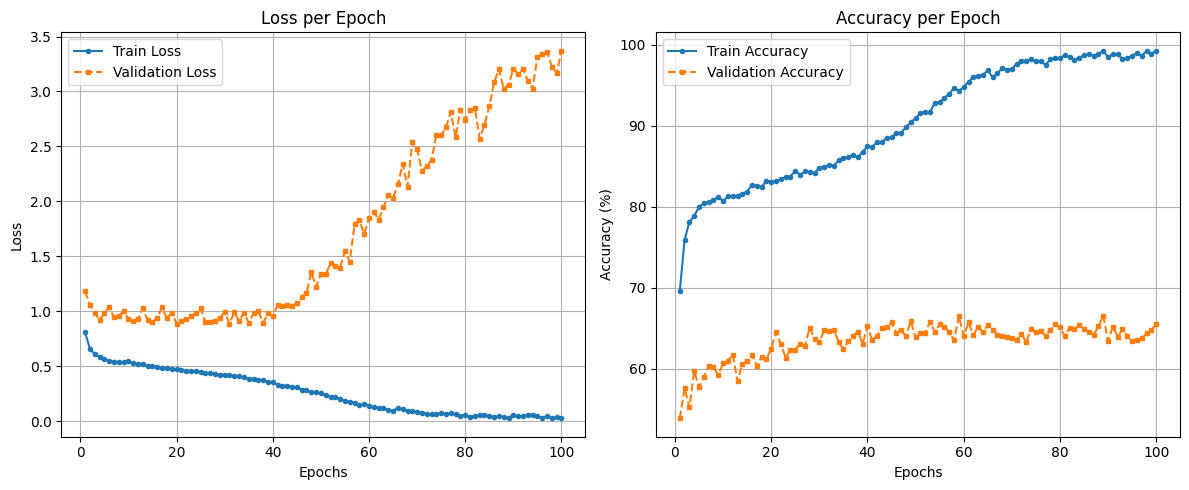

📈 학습 결과 시각화 저장 완료: /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/trainval_curve.png


In [19]:
def plot_train_test_results(
    train_losses,
    train_scores,
    val_losses,
    val_scores,
    ):
    """
    학습 및 검증 과정의 Loss 및 Accuracy를 시각화하는 함수 (Train + Val).
    """
    epochs = np.arange(1, len(train_losses) + 1)

    fig = plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker="o", markersize=3, linestyle="-", label="Train Loss")
    plt.plot(epochs, val_losses, marker="s", markersize=3, linestyle="--", label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_scores, marker="o", markersize=3, linestyle="-", label="Train Accuracy")
    plt.plot(epochs, val_scores, marker="s", markersize=3, linestyle="--", label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    plot_path = os.path.join(cfg.results_save_path, f"trainval_curve.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"📈 학습 결과 시각화 저장 완료: {plot_path}")

plot_train_test_results(
    train_losses,
    train_scores,
    valid_losses,
    valid_scores,
)

## confusion matrix, classification_report 시각화

In [20]:
# 모델 로드 함수
def load_model(model, device, model_type=ModelType.BEST):
    """저장된 모델을 불러오는 함수"""
    model_path = os.path.join(cfg.model_save_path, f"{model_type.value}_model.pth")
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_path}")
    return model

# Confusion Matrix 시각화 함수
def plot_confusion_matrix_and_report(
    y_true,
    y_pred,
    data_type,
    model_type=ModelType.BEST
    ):
    """
    Confusion Matrix를 그리는 함수
    """
    # == confusion matrix ==
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cfg.labels, yticklabels=cfg.labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    file_prefix = f"{model_type.value}_{data_type.value}"
    cm_path = os.path.join(cfg.results_save_path, f"{file_prefix}_confusion_matrix.png")
    plt.savefig(cm_path, dpi=300)  # 이미지 저장
    plt.show()
    plt.close()
    print(f"✅ Confusion Matrix saved at: {cm_path}")

    # == classification report ==
    report = classification_report(y_true, y_pred, target_names=cfg.labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # 시각화
    fig, ax = plt.subplots(figsize=(10, len(report_df) * 0.6))
    ax.axis('off')

    table = ax.table(
        cellText=report_df.round(3).values,
        colLabels=report_df.columns,
        rowLabels=report_df.index,
        loc='center',
        cellLoc='center'
    )

    # 헤더 설정
    for j in range(len(report_df.columns)):
        cell = table[0, j]
        cell.set_facecolor('#d0d0d0')
        cell.set_fontsize(13)
        cell.set_text_props(weight='bold')

    # 셀 스타일 조정
    for i in range(len(report_df)):
        for j in range(len(report_df.columns)):
            cell = table[i + 1, j]
            cell.set_fontsize(12)
            cell.set_height(0.09)
            cell.set_facecolor('#a9a9a9' if i % 2 == 0 else '#ffffff')

    # 행 라벨 스타일 조정
    for i in range(len(report_df)):
        row_label = table[i + 1, -1] if (i + 1, -1) in table._cells else table[i + 1, 0]
        row_label.set_fontsize(12)
        row_label.set_text_props(weight='bold')
        row_label.set_height(0.09)

    cr_path = os.path.join(cfg.results_save_path, f"{file_prefix}_classification_report.png")
    plt.savefig(cr_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"📋 Classification Report table saved at: {cr_path}")


def evaluate_model(model, device, data_loader, data_type, model_type=ModelType.BEST):
    """
    모델을 평가
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = model(x_batch)  # (batch, num_classes)
            # 튜플 처리
            if isinstance(logits, tuple):
                logits = logits[0]
            probs = F.softmax(logits, dim=1)  # 확률로 변환

            y_pred_classes = torch.argmax(probs, dim=1)

            all_preds.extend(y_pred_classes.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # 각 샘플의 확률 벡터 저장

    # Confusion Matrix 출력
    plot_confusion_matrix_and_report(all_labels, all_preds, data_type, model_type)

    return all_labels, all_preds, np.array(all_probs)

In [21]:
model = load_model(model, cfg.device) # best model load

✅ Model Loaded from /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/weights/best_model.pth


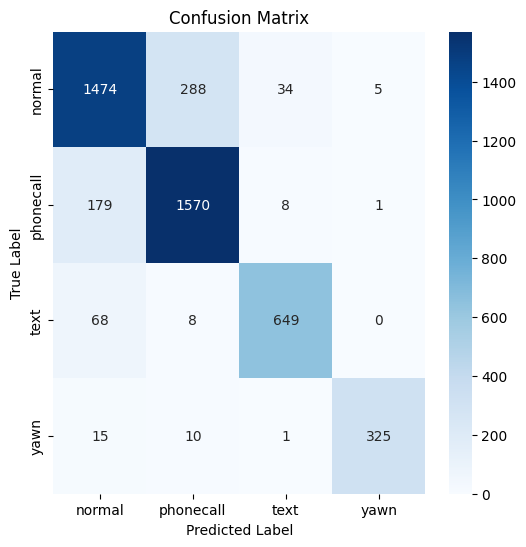

✅ Confusion Matrix saved at: /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/best_train_confusion_matrix.png


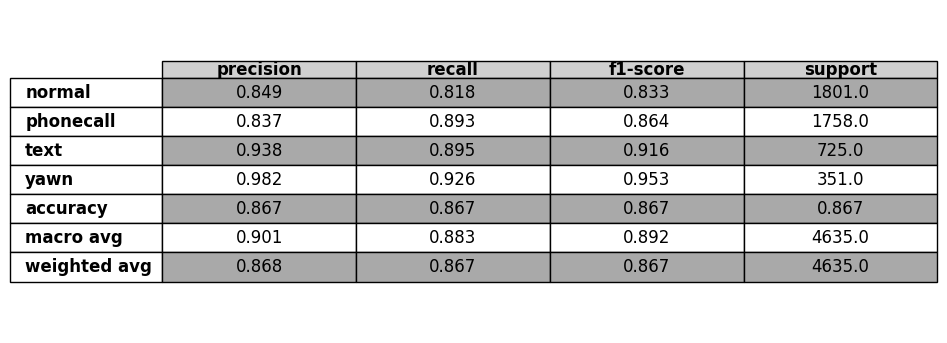

📋 Classification Report table saved at: /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/best_train_classification_report.png


In [22]:
# 평가하기 위해서 shuffle=False 로 구성된 DataLoader를 따로 만들어야 함
train_loader_eval = DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,         # 중요: 순서 유지
    num_workers=0,
    pin_memory=cfg.use_cuda
)

train_labels, train_preds, train_probs = evaluate_model(model, cfg.device, train_loader_eval, DataType.TRAIN)

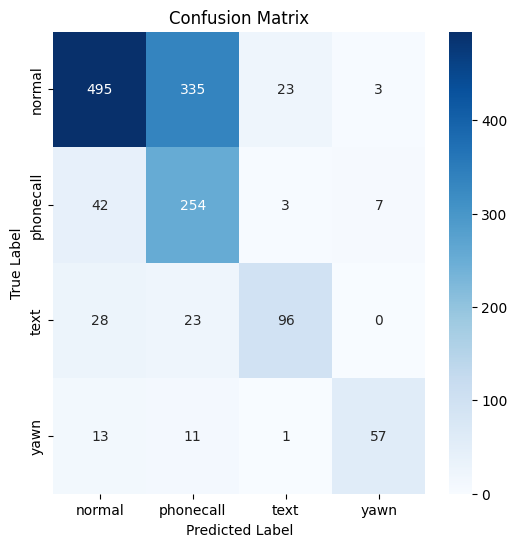

✅ Confusion Matrix saved at: /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/best_val_confusion_matrix.png


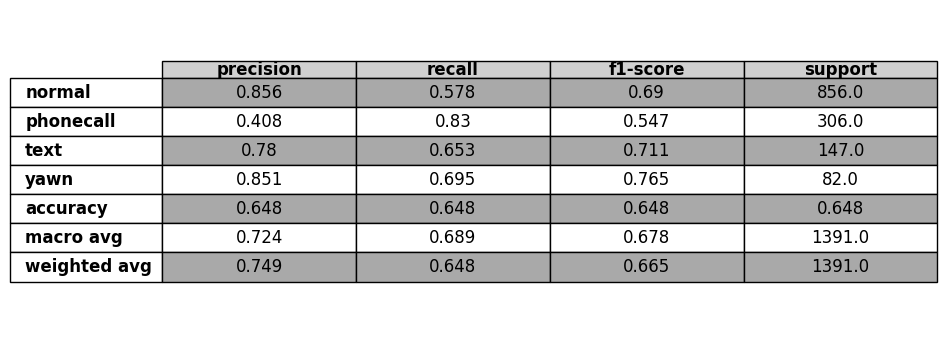

📋 Classification Report table saved at: /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/best_val_classification_report.png


In [23]:
val_labels, val_preds, val_probs = evaluate_model(model, cfg.device, val_loader, DataType.VAL)

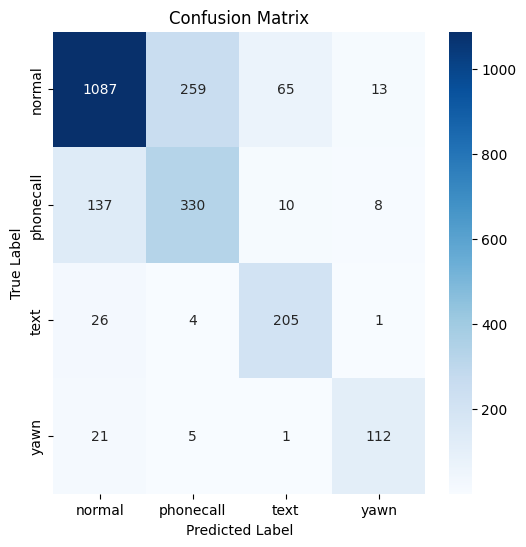

✅ Confusion Matrix saved at: /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/best_test_confusion_matrix.png


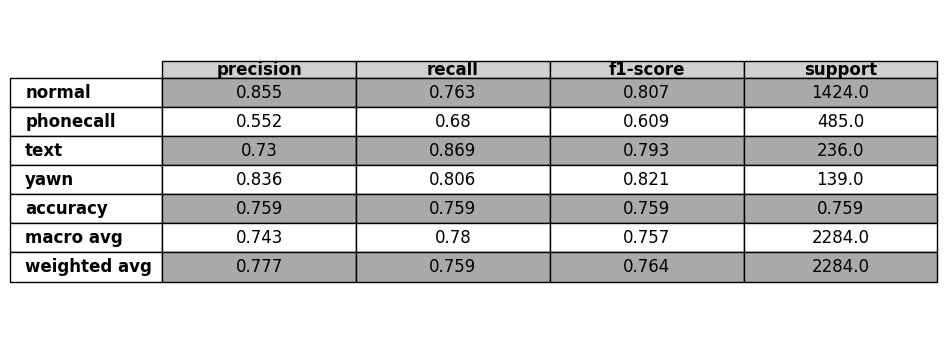

📋 Classification Report table saved at: /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/best_test_classification_report.png


In [24]:
test_labels, test_preds, test_probs = evaluate_model(model, cfg.device, test_loader, DataType.TEST)

## 오분류 데이터 확인하기

#### 클래스별 확신 높은 오분류 top-10 인덱스 추출

In [25]:
def get_top_wrong_by_class(y_true, y_pred, y_prob, top_k=10, label_decoding=cfg.label_decoding):
    """
    각 클래스에서 확신(confidence)이 높은 오분류 top-k 샘플 인덱스를 반환

    Returns:
        result_dict: {class_name: [index1, index2, ...]} 형태
    """
    num_classes = len(label_decoding)
    wrong_by_class = {label_decoding[c]: [] for c in range(num_classes)}

    for i, (t, p) in enumerate(zip(y_true, y_pred)):
        if t != p:
            pred_confidence = y_prob[i][p]
            pred_class_name = label_decoding[p]
            wrong_by_class[pred_class_name].append((i, pred_confidence))

    # 각 클래스별 confidence 높은 순으로 정렬 후 top-k만 추출
    result_dict = {}
    for class_name, wrong_list in wrong_by_class.items():
        top_k_sorted = sorted(wrong_list, key=lambda x: x[1], reverse=True)[:top_k]
        result_dict[class_name] = [idx for idx, _ in top_k_sorted]

    return result_dict

### 오분류 데이터 프레임 시각화

In [26]:
def show_misclassified_sequence(y_true, y_pred, metadata, data_df, index):
    """
    잘못 분류된 샘플 중 하나의 시퀀스를 시각화하는 함수

    Args:
        y_true (list): 실제 정답 라벨들
        y_pred (list): 모델이 예측한 라벨들
        metadata (list of tuples): (label, clip_id, start_frame_index)
        data_df (pd.DataFrame): 전체 프레임 데이터프레임 (frame_path 포함)
        index (int): 보고 싶은 틀린 샘플의 인덱스 (0부터 시작)
    """
    true_label = y_true[index]
    pred_label = y_pred[index]
    label, clip_id, start_frame = metadata[index]

    true_label = cfg.label_decoding[true_label]
    pred_label = cfg.label_decoding[pred_label]

    print(f"\n🔍 오분류 예시 #{index}")
    print(f"Clip ID: {clip_id}, Start Frame: {start_frame}")
    print(f"True Label: {true_label}, Predicted: {pred_label}")

    # 해당 시퀀스 프레임 추출
    frame_range = list(range(start_frame, start_frame + cfg.sequence_length))
    clip_df = data_df[(data_df["label"] == true_label) &
                      (data_df["clip_id"] == clip_id) &
                      (data_df["frame_no"].isin(frame_range))].sort_values("frame_no")
    frame_paths = clip_df["frame_path"].tolist()
    print(f"첫번째 프레임의 frame_path: ", frame_paths[0])

    # 시각화
    n = len(frame_paths)
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2.5))
    if n == 1:
        axes = [axes]

    for i, (ax, path) in enumerate(zip(axes, frame_paths)):
        try:
            img = Image.open(path)
            ax.imshow(img)
            ax.set_title(f"#{i + start_frame}")
            ax.axis('off')
        except Exception:
            ax.text(0.5, 0.5, 'Image Load Fail', ha='center', va='center')
            ax.axis('off')

    plt.suptitle(f"Wrong Prediction\nTrue: {true_label} / Pred: {pred_label}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [27]:
get_top_wrong_by_class(train_labels, train_preds, train_probs)

{'normal': [1924, 1840, 2328, 3772, 2538, 2838, 2914, 4110, 4114, 2917],
 'phonecall': [1349, 1477, 761, 1027, 751, 298, 183, 658, 515, 102],
 'text': [153, 881, 1312, 1305, 400, 397, 1451, 1450, 991, 844],
 'yawn': [1215, 1242, 3056, 1379, 1243, 614]}


🔍 오분류 예시 #299
Clip ID: gF-22(File21)_s1_face_2019-03-04-14;54;55_22_12.avi, Start Frame: 24
True Label: normal, Predicted: normal
첫번째 프레임의 frame_path:  /content/drive/MyDrive/DMS/data/processed/dmd_frames_resized/Normal/gF-22(File21)_s1_face_2019-03-04-14;54;55_22_12.avi/frame000024.jpg


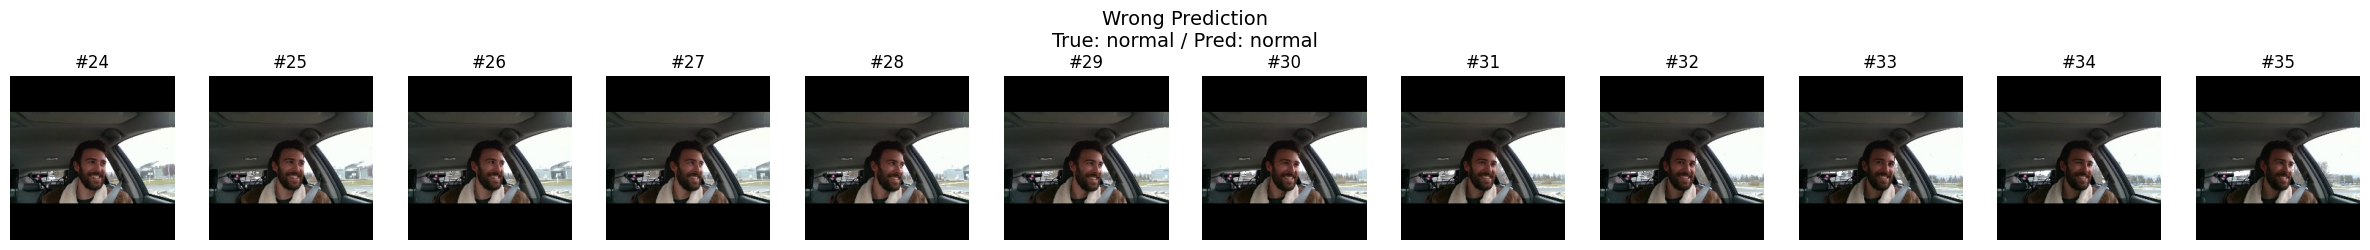

In [28]:
# 예를 들어 7490번째 틀린 예측을 보고 싶을 때
show_misclassified_sequence(
    y_true=train_labels,
    y_pred=train_preds,
    metadata=train_metadata,
    data_df=train_df,
    index=299
)

## Attention 시각화 함수

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import math
import os

def visualize_attention_by_class(model, dataset, class_indices: dict, feature_names=None, max_samples_per_class=1):
    """
    여러 클래스의 attention 분포를 비교 시각화합니다.

    Args:
        model: 학습된 LSTM+Attention 모델
        dataset: TensorDataset
        class_indices: {label_name(str): [indices]} - 클래스별 시각화할 인덱스 리스트
        feature_names: feature 이름 리스트
        max_samples_per_class: 각 클래스에서 시각화할 최대 샘플 수
    """

    model.eval()
    num_classes = len(class_indices)
    feature_names = feature_names or [f'F{i}' for i in range(len(cfg.features))]

    fig, axes = plt.subplots(2, num_classes, figsize=(4 * num_classes, 6))  # 2 rows, N cols

    if num_classes == 1:
        axes = np.expand_dims(axes, axis=1)  # (2,1) 모양으로 강제 reshape

    for i, (label_name, indices) in enumerate(class_indices.items()):
        sample_idx = indices[0]
        x_seq, label = dataset[sample_idx]
        x_seq = x_seq.unsqueeze(0).to(cfg.device)

        with torch.no_grad():
            output, attn_weights = model(x_seq)

        attn_weights = attn_weights.squeeze().cpu().numpy()  # [T]
        x_np = x_seq.squeeze().cpu().numpy()                 # [T, F]
        time_steps = list(range(len(attn_weights)))

        # Feature Heatmap
        ax1 = axes[0][i]
        sns.heatmap(x_np.T, cmap='viridis', cbar=True, xticklabels=time_steps,
                    yticklabels=feature_names, ax=ax1)
        ax1.set_title(f"[{label_name}] Input Features")
        ax1.set_xlabel("Time Step")
        ax1.set_ylabel("Feature")

        # Attention Barplot
        ax2 = axes[1][i]
        sns.barplot(x=time_steps, y=attn_weights, ax=ax2)
        ax2.set_title(f"[{label_name}] Attention Weights")
        ax2.set_xlabel("Time Step")
        ax2.set_ylabel("Weight")

    plt.tight_layout()
    save_path = os.path.join(cfg.results_save_path, "attention_comparison_2x4.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"✅ Attention comparison saved at: {save_path}")


In [30]:
from collections import defaultdict

def get_class_indices(dataset, label_decoding):
    class_indices = defaultdict(list)

    for idx in range(len(dataset)):
        _, label_idx = dataset[idx]
        label_name = label_decoding[label_idx.item()]
        class_indices[label_name].append(idx)

    return class_indices


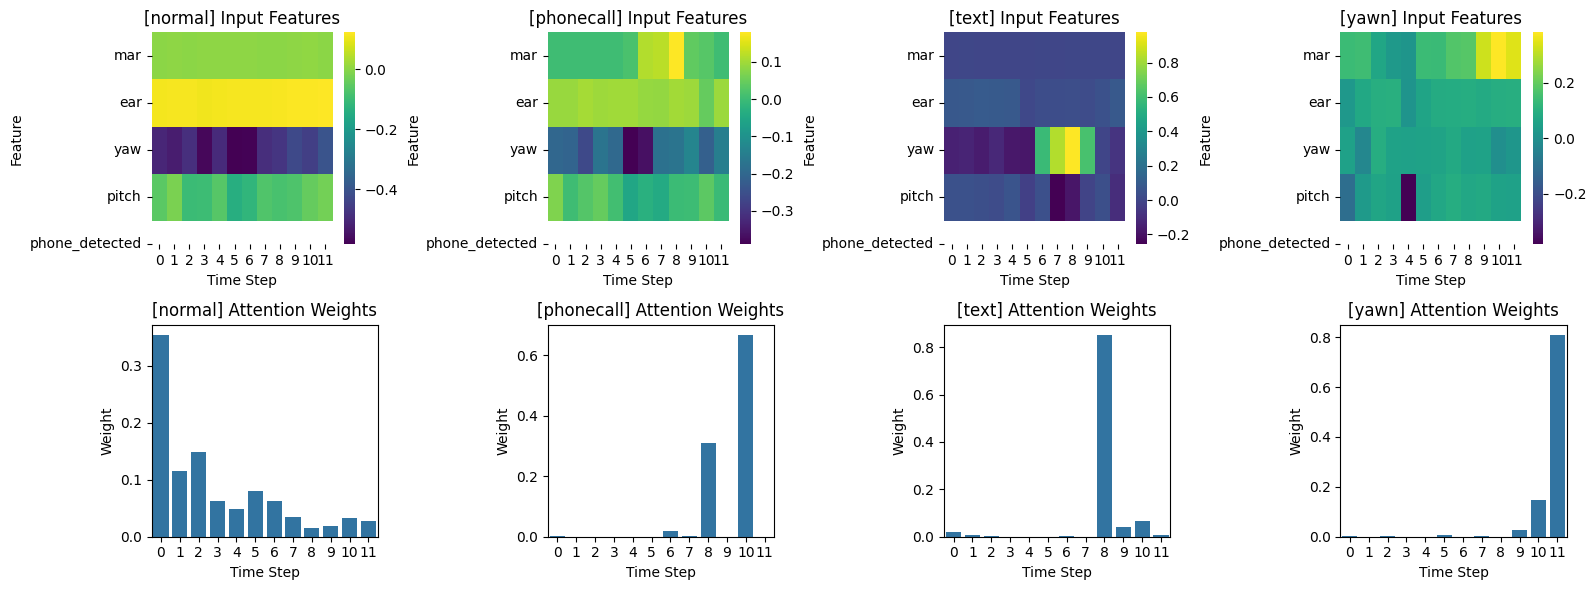

✅ Attention comparison saved at: /content/drive/MyDrive/DMS/runs/bi-lstm_attention_no_phone_detection/attention_comparison_2x4.png


In [31]:
class_indices = get_class_indices(val_dataset, cfg.label_decoding)
selected_indices = {cls: [idxs[0]] for cls, idxs in class_indices.items()}

visualize_attention_by_class(model, val_dataset, selected_indices, feature_names=['mar', 'ear', 'yaw', 'pitch', 'phone_detected'])